In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [243]:

file_path = 'all_upwork_jobs_2024-02-07-2024-03-24.csv'
df = pd.read_csv(file_path)

print(df.shape)
df.head()

df.info()
df.isnull().sum()

(244828, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

In [244]:
# -------------------------------
# 4. Data Cleaning & Preprocessing
# -------------------------------

# Drop rows without salary
df = df.dropna(subset=['hourly_low', 'hourly_high'])

# Average hourly salary
df['avg_hourly_rate'] = (df['hourly_low'] + df['hourly_high']) / 2

# Parse date (CORRECT column name)
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])

# Monthly grouping
df['month'] = df['published_date'].dt.to_period('M')

# Clean job title
df['job_title_clean'] = (
    df['title']
    .str.lower()
    .str.replace('[^a-zA-Z ]', '', regex=True)
)

# Derived job category (since CSV has no job_category)
df['job_category'] = (
    df['job_title_clean']
    .str.split()
    .str[:2]
    .str.join(' ')
)

# Remote flag (derived from title, since work_type column does NOT exist)
df['is_remote'] = df['title'].str.contains('remote', case=False).astype(int)

# Country cleanup
df['country'] = df['country'].fillna('Unknown')


C:\Users\ompra\AppData\Local\Temp\ipykernel_26988\4150688361.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M')


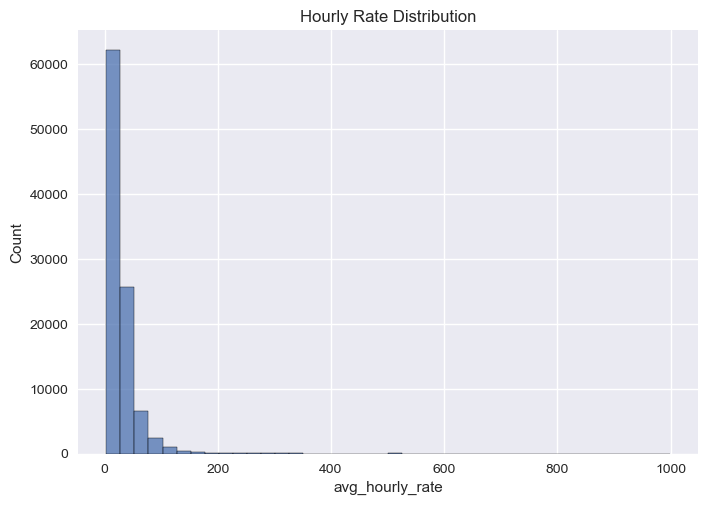

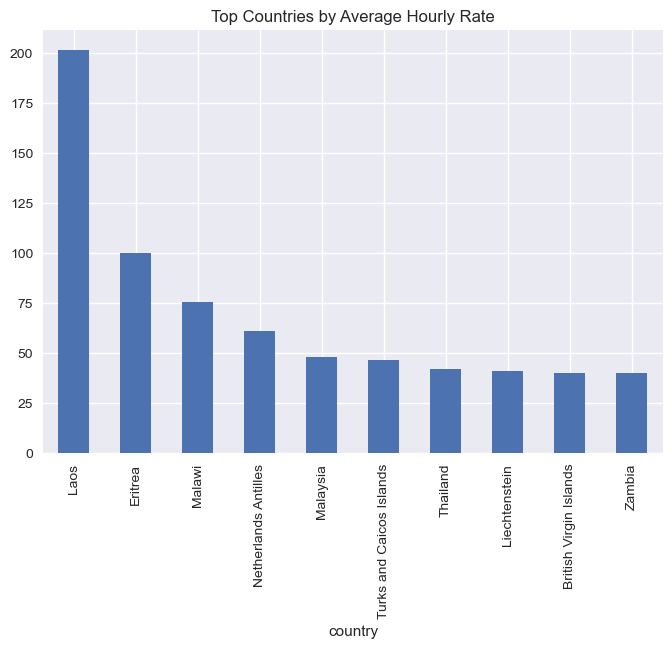

In [245]:
# -------------------------------
# 5. Exploratory Data Analysis (EDA)
# -------------------------------

plt.figure()
sns.histplot(df['avg_hourly_rate'], bins=40)
plt.title('Hourly Rate Distribution')
plt.show()

country_salary = df.groupby('country')['avg_hourly_rate'].mean().sort_values(ascending=False).head(10)

plt.figure()
country_salary.plot(kind='bar')
plt.title('Top Countries by Average Hourly Rate')
plt.show()

# -------------------------------

In [246]:
# 6. Task 1: Job Title Keywords vs Salary (TF-IDF)
# -------------------------------

tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_tfidf = tfidf.fit_transform(df['job_title_clean'])

salary_model = RandomForestRegressor(n_estimators=200, random_state=42)
salary_model.fit(X_tfidf, df['avg_hourly_rate'])

feature_importance = pd.Series(salary_model.feature_importances_, index=tfidf.get_feature_names_out())
feature_importance.sort_values(ascending=False).head(15)


sales          0.053692
assistant      0.043765
work           0.039844
needed         0.026518
company        0.024355
development    0.022842
ads            0.022396
consultant     0.020695
facebook       0.019545
expert         0.019470
support        0.018824
business       0.018794
lead           0.018300
marketing      0.016857
data           0.016209
dtype: float64

In [247]:
# -------------------------------
# 7. Task 2: Emerging Job Categories
# -------------------------------

df['month'] = df['published_date'].dt.to_period('M')
category_trends = df.groupby(['month', 'job_category']).size().unstack(fill_value=0)
category_growth = category_trends.pct_change().mean().sort_values(ascending=False)

category_growth.head(10)

C:\Users\ompra\AppData\Local\Temp\ipykernel_26988\1744329104.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M')


job_category
                         inf
portfolio website        inf
porting windows          inf
portland based           inf
portless account         inf
portrait and             inf
portrait illustration    inf
portrait live            inf
portrait of              inf
portrait photographer    inf
dtype: float64

In [248]:
# -------------------------------
# 8. Task 3: High-Demand Job Role Prediction
# -------------------------------

role_demand = df.groupby(['month', 'job_category']).size().reset_index(name='count')

encoder = LabelEncoder()
role_demand['job_encoded'] = encoder.fit_transform(role_demand['job_category'])
role_demand['month_num'] = role_demand['month'].astype(str).str.replace('-', '').astype(int)

X = role_demand[['job_encoded', 'month_num']]
y = role_demand['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

demand_model = GradientBoostingRegressor(n_estimators=300)
demand_model.fit(X_train, y_train)

y_pred = demand_model.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 13.522576561860246


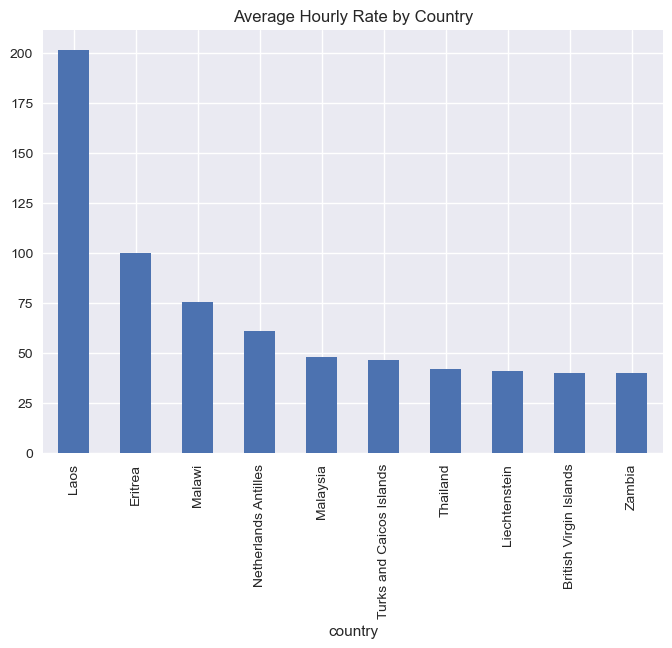

In [249]:
country_rates = (
    df.groupby('country')['avg_hourly_rate']
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
country_rates.head(10).plot(kind='bar')
plt.title('Average Hourly Rate by Country')
plt.show()


In [250]:
# -------------------------------
# 10. Task 5: Job Recommendation Engine (MEMORY SAFE)
# -------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Limit vocabulary to reduce memory
tfidf_rec = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

job_matrix = tfidf_rec.fit_transform(df['job_title_clean'])

def recommend_jobs(job_index, top_n=5):
    # Compute similarity ONLY for one job
    cosine_scores = cosine_similarity(
        job_matrix[job_index], 
        job_matrix
    ).flatten()
    
    # Get top matches
    similar_indices = cosine_scores.argsort()[-top_n-1:-1][::-1]
    
    return df.iloc[similar_indices][
        ['title', 'avg_hourly_rate', 'country']
    ]

# Example
recommend_jobs(10)


,title,avg_hourly_rate,country
209038,COO Consultation,75.0,Czech Republic
30928,COO to interview,125.0,United Kingdom
142647,COO needed with EOS Integration background,90.0,United States
146602,Fractional COO with Tech/Marketing Background,102.0,United States
68080,Experienced COO Needed for Long-Term Ecommerce...,41.5,Netherlands


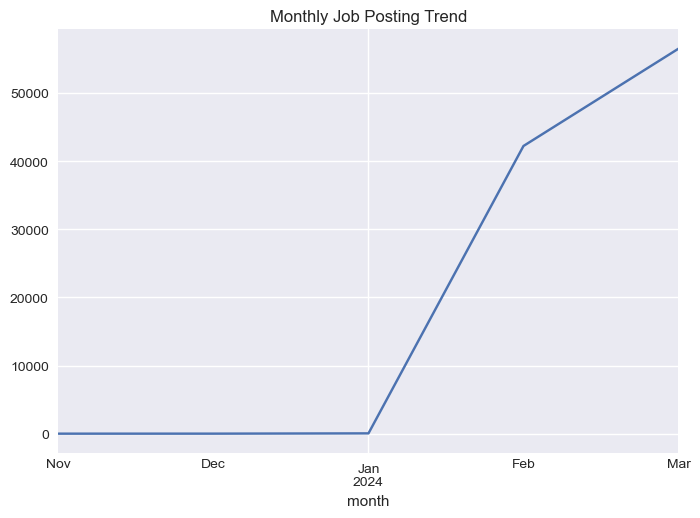

In [251]:
# -------------------------------
# 11. Task 6: Monthly Job Market Dynamics
# -------------------------------

monthly_jobs = df.groupby('month').size()

plt.figure()
monthly_jobs.plot()
plt.title('Monthly Job Posting Trend')
plt.show()

# -------------------------------

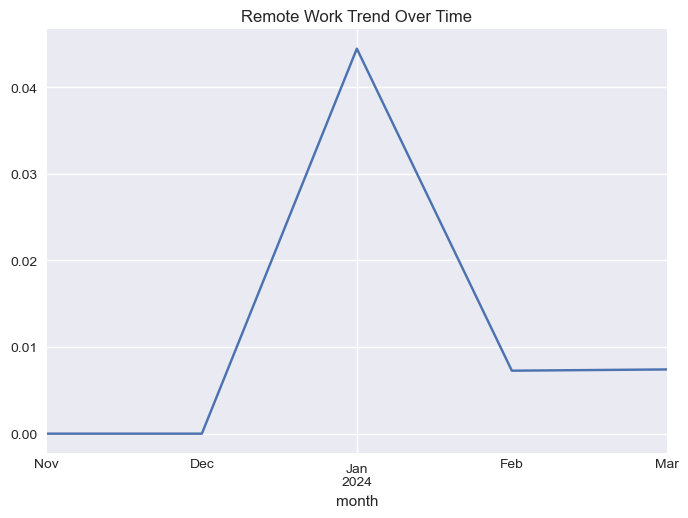

In [252]:

# 12. Task 7: Remote Work Trends
# -------------------------------

remote_trend = df.groupby('month')['is_remote'].mean()

plt.figure()
remote_trend.plot()
plt.title('Remote Work Trend Over Time')
plt.show()


In [253]:
# -------------------------------
# 13. Task 8: Future Job Market Prediction
# -------------------------------

future_X = X_test.copy()
future_predictions = demand_model.predict(future_X)

pd.DataFrame({
    'Predicted_Demand': future_predictions
}).head()

# -------------------------------
# 14. Final Conclusion
# -------------------------------

print('Project Completed Successfully')

Project Completed Successfully


In [254]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8")


In [255]:
df = pd.read_csv("all_upwork_jobs_2024-02-07-2024-03-24.csv")

df.head()


,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India


In [256]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


In [257]:
# Convert date column
df['published_date'] = pd.to_datetime(df['published_date'])

# Create unified salary column
df['salary'] = np.where(
    df['is_hourly'] == True,
    (df['hourly_low'] + df['hourly_high']) / 2,
    df['budget']
)

# Handle missing salary values
df['salary'] = df['salary'].fillna(df['salary'].median())

# All Upwork jobs are remote
df['is_remote'] = 1

df[['title', 'salary', 'country', 'published_date']].head()


,title,salary,country,published_date
0,Experienced Media Buyer For Solar Pannel and R...,500.0,NaN,2024-02-17 09:09:54+00:00
1,Full Stack Developer,1100.0,United States,2024-02-17 09:09:17+00:00
2,SMMA Bubble App,20.0,United States,2024-02-17 09:08:46+00:00
3,Talent Hunter Specialized in Marketing,32.5,United States,2024-02-17 09:08:08+00:00
4,Data Engineer,650.0,India,2024-02-17 09:07:42+00:00


In [258]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df['title'].fillna(""))
y = df['salary']


In [259]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

importance = model.feature_importances_
feature_names = tfidf.get_feature_names_out()

keyword_importance = pd.DataFrame({
    'keyword': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

keyword_importance.head(10)


,keyword,importance
265,digital,0.166231
180,cold,0.108930
905,token,0.072139
212,copywriter,0.048443
538,manager,0.041104
351,financial,0.038616
773,sales,0.035472
575,month,0.033688
529,mail,0.031436
480,jobs,0.031030


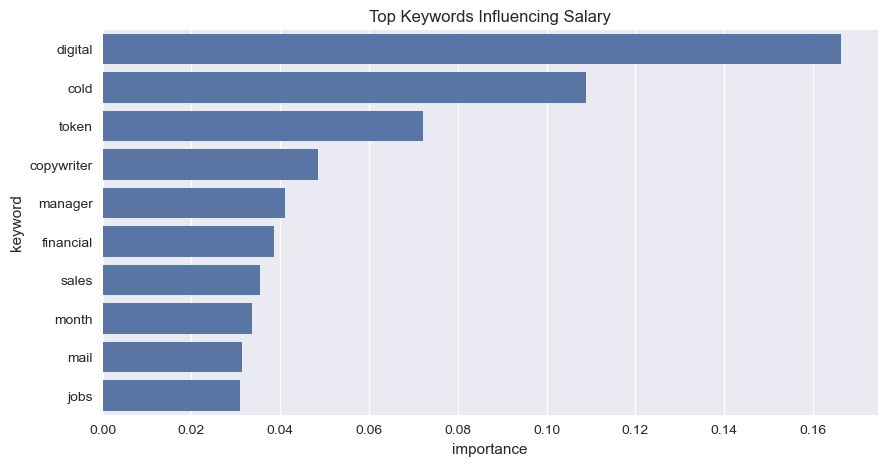

In [260]:
top_keywords = keyword_importance.head(10)

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='keyword', data=top_keywords)
plt.title("Top Keywords Influencing Salary")
plt.show()


In [261]:
df['month'] = df['published_date'].dt.to_period('M').astype(str)

monthly_titles = df.groupby(['month', 'title']).size().reset_index(name='count')

emerging_roles = monthly_titles.sort_values(['month', 'count'], ascending=False)
emerging_roles.head()


C:\Users\ompra\AppData\Local\Temp\ipykernel_26988\1649008269.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M').astype(str)


,month,title,count
186551,2024-03,Social Media Manager,245
197724,2024-03,Video Editor,202
148147,2024-03,Logo Design,201
134866,2024-03,Graphic Designer,172
199542,2024-03,Virtual Assistant,166


In [262]:
monthly_demand = df.groupby('month').size().reset_index(name='job_count')

monthly_demand['time_index'] = range(len(monthly_demand))

X = monthly_demand[['time_index']]
y = monthly_demand['job_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
rmse


D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


40949.02898541893

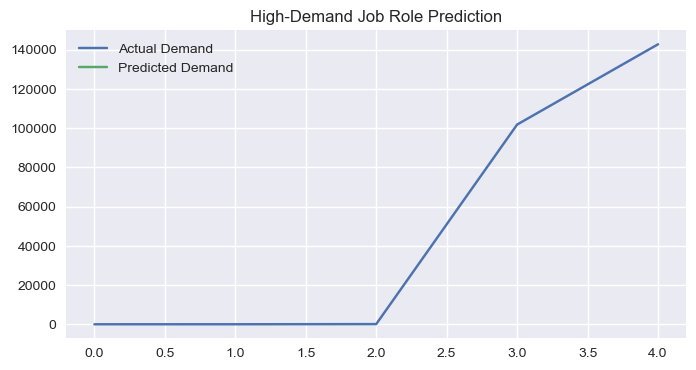

In [263]:
plt.figure(figsize=(8,4))
plt.plot(monthly_demand['job_count'], label='Actual Demand')
plt.plot(range(len(X_train), len(X_train)+len(predictions)), predictions, label='Predicted Demand')
plt.legend()
plt.title("High-Demand Job Role Prediction")
plt.show()


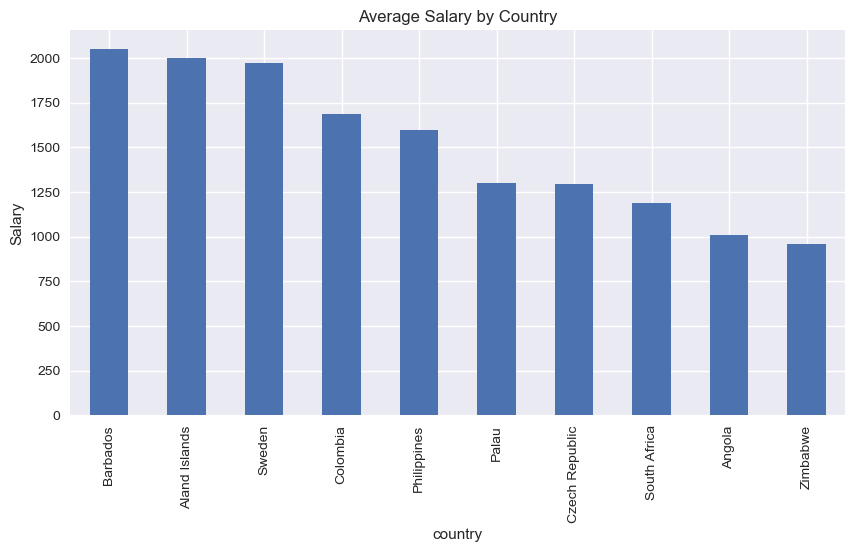

In [264]:
country_salary = df.groupby('country')['salary'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
country_salary.plot(kind='bar')
plt.title("Average Salary by Country")
plt.ylabel("Salary")
plt.show()


In [265]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure clean text
titles = df['title'].fillna("").astype(str)

# Limit features to control memory
tfidf_rec = TfidfVectorizer(
    stop_words='english',
    max_features=300
)

job_matrix = tfidf_rec.fit_transform(titles)

def recommend_jobs(job_index, top_n=5):
    if job_index >= len(df):
        return "Invalid job index"

    # Compute similarity ONLY for the selected job
    sim_scores = cosine_similarity(
        job_matrix[job_index],
        job_matrix
    ).flatten()

    # Get top matches (excluding itself)
    top_indices = sim_scores.argsort()[::-1][1:top_n+1]

    return df.iloc[top_indices][['title', 'country', 'salary']]


In [266]:
recommend_jobs(10)


,title,country,salary
40821,Create a 3D model of a helmet from pictures fo...,Austria,25.0
209463,Create a 3D Model for a Massage Tool (For 3D P...,Singapore,30.0
80010,3D Modeler - Create a 3d model of a medieval door,Portugal,50.0
48695,3D Character Modeler to create a model with pr...,Canada,27.5
97639,3D Pet Model Designer of Pets 3D printing,India,20.0


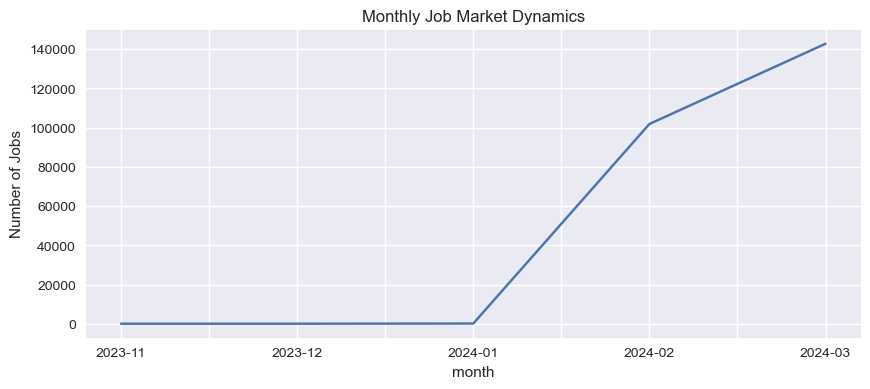

In [267]:
monthly_jobs = df.groupby('month').size()

plt.figure(figsize=(10,4))
monthly_jobs.plot()
plt.title("Monthly Job Market Dynamics")
plt.ylabel("Number of Jobs")
plt.show()


In [268]:
remote_percentage = df['is_remote'].mean() * 100
remote_percentage


100.0

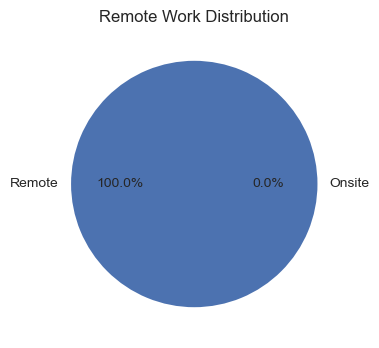

In [269]:
plt.figure(figsize=(4,4))
plt.pie([remote_percentage, 100-remote_percentage], labels=['Remote', 'Onsite'], autopct='%1.1f%%')
plt.title("Remote Work Distribution")
plt.show()


D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


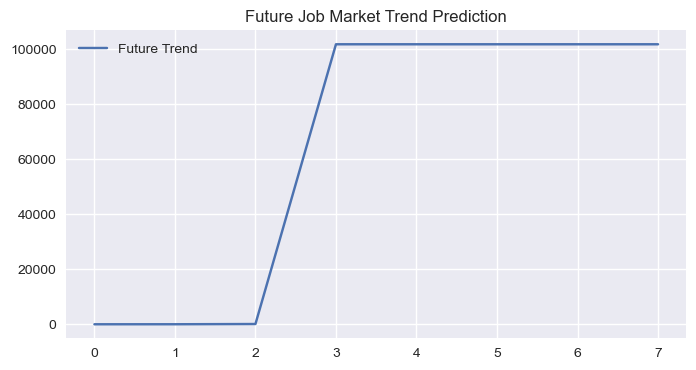

In [270]:
future_time = np.array(range(len(monthly_demand)+3)).reshape(-1,1)
future_predictions = model.predict(future_time)

plt.figure(figsize=(8,4))
plt.plot(future_predictions, label='Future Trend')
plt.title("Future Job Market Trend Prediction")
plt.legend()
plt.show()
